#Avaliação dos dados sintéticos
Conjunto de dados: `Palmer Penguins` (Pinguins de Palmer) <br>

-Autoras: <br>
Ana Luíza Gomes Vieira (analuizagv2000@gmail.com) <br>
Sarah Vitória Moreira de Aquino (sarahvitoriaaquino@gmail.com)<br>

-Data: <br>
Agosto de 2025

---

In [ ]:
!pip install sdmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.4 MB/s eta 0:00:00


#Importação das bibliotecas e datasets

In [ ]:
import pandas as pd
import io
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
metadados_upload = files.upload()

Saving metadata.json to metadata.json


In [ ]:
sintetico_upload = files.upload()

Saving dados_sinteticos.json to dados_sinteticos.json


In [ ]:
metadados = pd.read_json(io.BytesIO(metadados_upload['metadata.json']))

In [ ]:
penguins_real = pd.read_csv('https://raw.githubusercontent.com/ftorresd/OCEAN-datasets/main/penguins/penguins.csv')

In [ ]:
penguins_sintetico = pd.read_json(io.BytesIO(sintetico_upload['dados_sinteticos.json']))

#Visão Geral dos Datasets

In [ ]:
penguins_real.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [ ]:
penguins_sintetico.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Chinstrap,Dream,41.9,15.6,202,3422,FEMALE
1,Adelie,Dream,36.2,15.6,186,3592,FEMALE
2,Adelie,Biscoe,44.7,20.0,203,4040,MALE
3,Gentoo,Biscoe,46.4,15.7,216,4408,FEMALE
4,Chinstrap,Dream,40.6,16.4,217,4076,MALE


In [ ]:
penguins_real.shape

(344, 7)

In [ ]:
penguins_sintetico.shape

(10000, 7)

In [ ]:
print(penguins_real.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


In [ ]:
print(penguins_sintetico.isnull().sum())

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


#Avaliação Geral

In [ ]:
penguins_sintetico.duplicated().sum()

np.int64(0)

In [ ]:
from sdmetrics.single_table import NewRowSynthesis

score = NewRowSynthesis.compute(
    real_data=penguins_real,
    synthetic_data=penguins_sintetico,
    metadata=metadados.to_dict(),
    numerical_match_tolerance=0.01,     # Tolerância de 1% para variáveis numéricas
    synthetic_sample_size=None          # Usa todos os dados sintéticos
)

In [ ]:
print("New Row Synthesis score:", score)

New Row Synthesis score: 0.9966


---
Score = 1.0 → sintético produz apenas combinações novas (não copiadas).

Score próximo de 0.0 → indica que o modelo está memorizando os dados, não aprendendo padrões.

Score intermediário (ex: 0.6) → cerca de 40% das linhas sintéticas são duplicatas.

---

In [ ]:
def corr_gap(real, synth, method='spearman'):
    num = real.select_dtypes(include=np.number).columns
    rC = real[num].corr(method=method)
    sC = synth[num].corr(method=method)
    diff = (rC - sC).abs()
    gap = np.linalg.norm(diff.values)
    worst_pairs = (diff.where(~np.eye(len(diff), dtype=bool)).stack()
                   .sort_values(ascending=False).head(10))
    return gap, worst_pairs

gap, worst = corr_gap(penguins_real, penguins_sintetico)
print("Correlation gap (↓ melhor):", gap)
worst


Correlation gap (↓ melhor): 0.17018065659854692


,,0
flipper_length_mm,body_mass_g,0.064092
body_mass_g,flipper_length_mm,0.064092
bill_length_mm,bill_depth_mm,0.056539
bill_depth_mm,bill_length_mm,0.056539
flipper_length_mm,bill_length_mm,0.049470
bill_length_mm,flipper_length_mm,0.049470
flipper_length_mm,bill_depth_mm,0.049303
bill_depth_mm,flipper_length_mm,0.049303
body_mass_g,bill_depth_mm,0.045869
bill_depth_mm,body_mass_g,0.045869


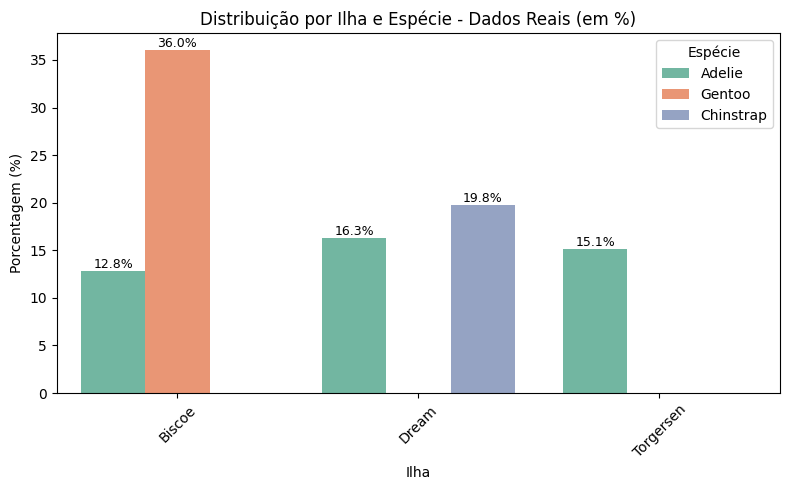

In [ ]:
temp = penguins_real.groupby(['island', 'species']).size().reset_index(name='count')
total = temp['count'].sum()
temp['percent'] = temp['count'] / total * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=temp, x='island', y='percent', hue='species', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=9)

plt.title("Distribuição por Ilha e Espécie - Dados Reais (em %)")
plt.xlabel("Ilha")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=45)
plt.legend(title='Espécie')
plt.tight_layout()
plt.show()

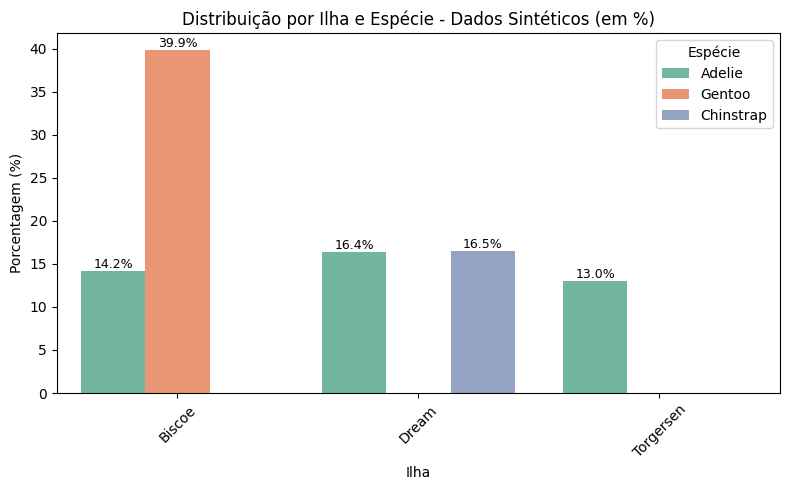

In [ ]:
temp = penguins_sintetico.groupby(['island', 'species']).size().reset_index(name='count')
total = temp['count'].sum()
temp['percent'] = temp['count'] / total * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=temp, x='island', y='percent', hue='species', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=9)

plt.title("Distribuição por Ilha e Espécie - Dados Sintéticos (em %)")
plt.xlabel("Ilha")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=45)
plt.legend(title='Espécie')
plt.tight_layout()
plt.show()

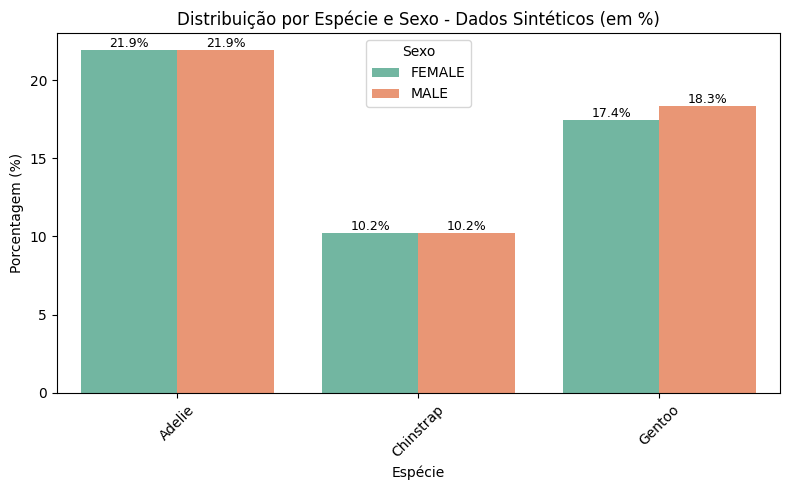

In [ ]:
temp = penguins_real.groupby(['species', 'sex']).size().reset_index(name='count')
total = temp['count'].sum()
temp['percent'] = temp['count'] / total * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=temp, x='species', y='percent', hue='sex', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=9)

plt.title("Distribuição por Espécie e Sexo - Dados Sintéticos (em %)")
plt.xlabel("Espécie")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=45)
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

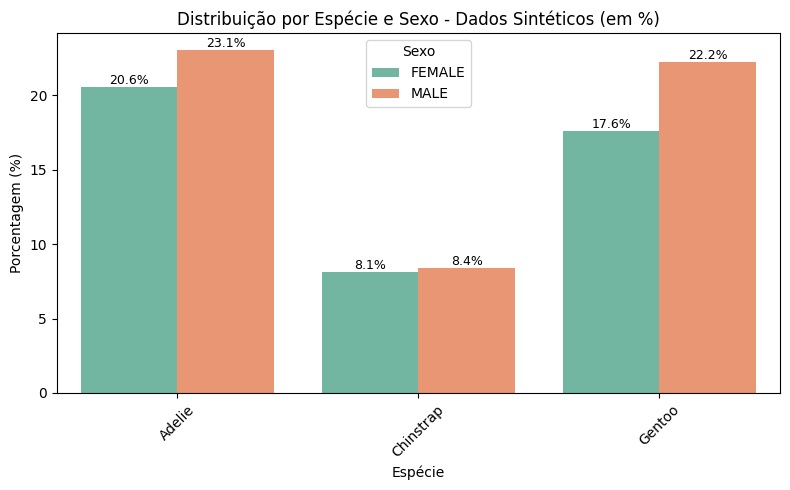

In [ ]:
temp = penguins_sintetico.groupby(['species', 'sex']).size().reset_index(name='count')
total = temp['count'].sum()
temp['percent'] = temp['count'] / total * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=temp, x='species', y='percent', hue='sex', palette='Set2')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', fontsize=9)

plt.title("Distribuição por Espécie e Sexo - Dados Sintéticos (em %)")
plt.xlabel("Espécie")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=45)
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

#Testes de generalização

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def fazer_preprocessador(X: pd.DataFrame) -> ColumnTransformer:
    num = X.select_dtypes(include=np.number).columns
    cat = [c for c in X.columns if c not in num]
    return ColumnTransformer([
        ('num', StandardScaler(with_mean=False), num),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat)
    ], remainder='drop')

In [ ]:
def _avaliar(y_true, y_pred, y_proba=None, labels=None):
    out = {
        'acc': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro')
    }
    if y_proba is not None and labels is not None and len(np.unique(y_true)) > 1:
        try:
            out['auroc_macro'] = roc_auc_score(
                y_true, y_proba, multi_class='ovr', labels=labels, average='macro'
            )
        except Exception:
            pass
    return out


TRTS- Treina no REAL, testa no SINTÉTICO

In [ ]:
def treinar_real_testar_sintetico(real: pd.DataFrame, sintetico: pd.DataFrame, alvo='species'):
    Xr, yr = real.drop(columns=[alvo]), real[alvo]
    Xr_tr, _, yr_tr, _ = train_test_split(Xr, yr, test_size=0.3, stratify=yr, random_state=42)

    Xs = sintetico.drop(columns=[alvo], errors='ignore')
    ys = sintetico[alvo] if alvo in sintetico.columns else None
    if ys is None:
        raise ValueError(f"O conjunto sintético não contém a coluna alvo '{alvo}'.")

    pre = fazer_preprocessador(Xr_tr)
    clf = RandomForestClassifier(n_estimators=300, random_state=42)

    pipe = Pipeline([('pre', pre), ('clf', clf)])
    pipe.fit(Xr_tr, yr_tr)

    y_pred = pipe.predict(Xs)
    y_proba = pipe.predict_proba(Xs)
    labels = pipe.classes_

    return {'TRTS': _avaliar(ys, y_pred, y_proba, labels)}

TSTR- Treina no SINTÉTICO, testa no REAL (holdout)

In [ ]:
def treinar_sintetico_testar_real(real: pd.DataFrame, sintetico: pd.DataFrame, alvo='species'):
    Xr, yr = real.drop(columns=[alvo]), real[alvo]
    Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.3, stratify=yr, random_state=42)

    Xs = sintetico.drop(columns=[alvo], errors='ignore')
    ys = sintetico[alvo] if alvo in sintetico.columns else None
    if ys is None:
        raise ValueError(f"O conjunto sintético não contém a coluna alvo '{alvo}'.")

    pre = fazer_preprocessador(Xr_tr)
    clf = RandomForestClassifier(n_estimators=300, random_state=42)

    pipe = Pipeline([('pre', pre), ('clf', clf)])
    pipe.fit(Xs, ys)

    y_pred = pipe.predict(Xr_te)
    y_proba = pipe.predict_proba(Xr_te)
    labels = pipe.classes_

    return {'TSTR': _avaliar(yr_te, y_pred, y_proba, labels)}

Uso

In [ ]:
real_ok   = penguins_real.dropna(subset=['species'])
sint_ok   = penguins_sintetico.dropna(subset=['species'])

res_trts  = treinar_real_testar_sintetico(real_ok, sint_ok, alvo='species')
res_tstr  = treinar_sintetico_testar_real(real_ok, sint_ok, alvo='species')

In [ ]:
print("\n=== TRTS (treina no REAL, testa no SINTÉTICO) ===")
print(res_trts['TRTS'])

print("\n=== TSTR (treina no SINTÉTICO, testa no REAL) ===")
print(res_tstr['TSTR'])


=== TRTS (treina no REAL, testa no SINTÉTICO) ===
{'acc': 0.8458, 'f1_macro': 0.8124694004158205, 'auroc_macro': np.float64(0.9340016179471284)}

=== TSTR (treina no SINTÉTICO, testa no REAL) ===
{'acc': 0.9134615384615384, 'f1_macro': 0.8996836619461454, 'auroc_macro': np.float64(0.9902392822521614)}
